In [1]:
from Module.config import get_cfg_defaults

cfg = get_cfg_defaults()

In [2]:
print(cfg.DATASET.CLASS_MAP)
print(cfg.DATASET.HIST_NAME)
class_map = {ele[0]: ele[1] for ele in cfg.DATASET.CLASS_MAP}

[[225, 0, 1, 'background'], [56, 1, 2, 'inflammatory infiltration'], [43, 2, 1, 'adipose tissue'], [53, 3, 1, 'sweat gland'], [45, 4, 2, 'hair follicles'], [42, 5, 1, 'dermis'], [54, 6, 1, 'sebaceous gland'], [41, 7, 2, 'epidermis'], [202, 8, 1, 'skeletal muscle'], [55, 9, 1, 'blood vessels']]
['background', 'inflammatory infiltration', 'adipose tissue', 'sweat gland', 'hair follicles', 'dermis', 'sebaceous gland', 'epidermis', 'skeletal muscle', 'blood vessels']


In [3]:
class_map

{225: 0, 56: 1, 43: 2, 53: 3, 45: 4, 42: 5, 54: 6, 41: 7, 202: 8, 55: 9}

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [5]:
import os
from Module.model import return_resnet
from hephaestus.data.ndpwrapper_v2 import Slide_ndpread
from skimage.color import rgb2hsv
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import math
import pandas as pd

In [6]:
SLIDE_LIST = [
"2019-10-30 02.05.46.ndpi",
"2019-10-30 02.04.50.ndpi",
"2019-10-30 02.09.05.ndpi",
"2019-10-30 02.07.27.ndpi",
"2019-10-30 02.10.47.ndpi",
"2019-10-30 02.14.37.ndpi",
"2019-10-30 02.18.03.ndpi",
"2019-10-30 02.19.24.ndpi",
"2019-10-30 02.15.32.ndpi",
"2019-10-30 02.23.07.ndpi",
"2019-10-30 01.59.42.ndpi",
"350013D01170 - 2019-10-30 02.21.40.ndpi",
"2019-10-30 02.01.19.ndpi",
"2019-10-30 02.02.21.ndpi",
"2019-10-30 02.03.40.ndpi",
"2019-10-30 02.05.46.ndpi"]

In [6]:
# load weight from model
checkpoint_dir  = "/workspace/skin/checkpoint/"
reload_file = "R-101-v1_512_E50_cls10_AUG.h5"
checkpoint_path = checkpoint_dir+reload_file

# reload model
model = return_resnet("R-101-v1", classNum=len(class_map), in_shape=cfg.DATASET.INPUT_SHAPE)
model.load_weights(checkpoint_path)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:
class SlidePredictor:
    def __init__(self, 
                 bbox_shape, 
                 slide_dir,
                 slide_name,
                 histologic_name,
                 classifier,
                 class_map,
                 batch_size=32,
                 fast=True,
                 five_crop = True,
                ):
        self.bbox_shape = bbox_shape
        self.slide_dir  = slide_dir
        self.slide_name = slide_name
        self.histologic_name = histologic_name
        self.classifier = classifier
        self.batch_size = batch_size
        self.five_crop  = five_crop
        self.colormap   = [(1, 1, 1),
                           (0.7098039215686275, 0.5333333333333333, 0.09411764705882353), 
                           (1.0, 0.3411764705882353, 0.13333333333333333), 
                           (0.9137254901960784, 0.11764705882352941, 0.38823529411764707), 
                           (0.803921568627451, 0.8627450980392157, 0.2235294117647059), 
                           (0.0, 0.0, 0.6), 
                           (0.2980392156862745, 0.6862745098039216, 0.3137254901960784), 
                           (0.611764705882353, 0.15294117647058825, 0.6901960784313725), 
                           (0.011764705882352941, 0.6627450980392157, 0.9568627450980393), 
                           (1, 0, 0),
                           (0.7098039215686275, 0.5333333333333333, 0.09411764705882353)
                           ]
        self.class_map=class_map

        self.this_slide = Slide_ndpread(os.path.join(slide_dir, slide_name))
        W, H = self.this_slide.get_size()
        w, h = bbox_shape[0], bbox_shape[1]
        self.W = W
        self.H = H
        
        self.w_stride = W//w if W%w==0 else W//w+1
        self.h_stride = H//h if H%h==0 else H//h+1
        self.prob_map = np.zeros((self.w_stride, self.h_stride, len(self.class_map)), dtype=np.float32)
        
        assert W//w*w <= W and H//h*h <= H
        self.tiny_slide = self.this_slide.get_patch_with_resize(coord=(0,0),
                                                                src_sz = (W//w*w, H//h*h),
                                                                dst_sz = (W//w, H//h)
                                                               )
        self.tiny_slide = np.pad(self.tiny_slide, 
                                 ((0, self.h_stride-self.tiny_slide.shape[0]),
                                  (0, self.w_stride-self.tiny_slide.shape[1]), 
                                  (0, 0)), 
                                 mode="reflect")
        self.background_mask = np.zeros((self.h_stride, self.w_stride))
        self.fast = fast
        if fast:
            self.background_mask = self._judge_bg()
        self._get_prob_map()
        self._class_heatmap = np.argmax(self.prob_map, axis=-1)
    
    def _judge_bg(self, expand=True):
        hsv_img = rgb2hsv(self.tiny_slide)
        saturation_img = hsv_img[:, :, 1]
        boolean_mask = np.array(saturation_img<0.05, dtype=np.int32)
        if not expand:
            return boolean_mask
        for w in range(boolean_mask.shape[1]):
            meet = 0
            for h in range(boolean_mask.shape[0]):
                if boolean_mask[h, w] == 0:
                    meet = 2
                elif meet > 0:
                    boolean_mask[h, w] = 0
                    meet -= 1
            meet = 0
            for h in range(boolean_mask.shape[0])[::-1]:
                if boolean_mask[h, w] == 0:
                    meet = 2
                elif meet > 0:
                    boolean_mask[h, w] = 0
                    meet -= 1
        return boolean_mask
        
    def crop(self, x, y):
        # perform five crop at coordinate x, y (left-upper vertex)
        # return: 5 np-image list[center, LUQ, RUQ, LLQ, RLQ]
        patch_size = self.bbox_shape[0]
        dirs = [(0, 0), (-patch_size//2, -patch_size//2), (patch_size//2, -patch_size//2), (-patch_size//2, patch_size//2), (patch_size//2, patch_size//2)]
        ret = []
        for dx, dy in dirs:
            ret.append(self.this_slide.get_patch_at_level((x+dx, y+dy), self.bbox_shape)/255.)
        return ret

    def _get_prob_map(self):
        # 277*76
        patches = []
        coords  = []

        for i in range(self.w_stride):
            begin_time = time.time()
            for j in range(self.h_stride):
                if self.fast and self.background_mask[j, i] != 0:
                    continue
                else:
                    try:
                        # if the slide ndpi file is corrupted, getting some patches may raise error
                        if self.five_crop:
                            patch = self.crop(self.bbox_shape[0]*i, self.bbox_shape[1]*j)
                        else:
                            patch = self.this_slide.get_patch_at_level((512*i, 512*j), 
                                                                       self.bbox_shape)/255.
                    except:
                        self.background_mask[j, i] = 1
                    if not self.fast:
                        saturation = rgb2hsv(patch[0] if self.five_crop else patch)[..., 1].mean()
                        if saturation < 0.05:
                            self.background_mask[j, i] = 1
                if self.background_mask[j, i] == 0:
                    if isinstance(patch, list):
                        patches.extend(patch)
                        coords.extend([(i, j) for k in range(len(patch))])
                    else:
                        patches.append(patch)
                        coords.append((i, j))
                    if len(patches) >= self.batch_size:
                    #if len(patches)%self.batch_size==self.batch_size-1:
                        preds = self.classifier(np.array(patches, dtype=np.float32)).numpy()
                        if self.five_crop:
                            for idx, coord in enumerate(coords[::5]):
                                self.prob_map[coord[0], coord[1]] = np.copy(np.mean(preds[5*idx:5*(idx+1)], axis=0))
                        else:
                            for idx, coord in enumerate(coords):
                                self.prob_map[coord[0], coord[1]] = np.copy(preds[idx])
                        patches.clear()
                        coords.clear()
            end_time = time.time()
            print("Column {:}/{:}: time elapse {:}".format(i, self.w_stride, end_time-begin_time), end='\r')
        
        if len(patches):
            preds = self.classifier(np.array(patches, dtype=np.float32)).numpy()
            if self.five_crop:
                for idx, coord in enumerate(coords[::5]):
                    self.prob_map[coord[0], coord[1]] = np.copy(np.mean(preds[5*idx:5*(idx+1)], axis=0))
            else:
                for idx, coord in enumerate(coords):
                    self.prob_map[coord[0], coord[1]] = np.copy(preds[idx])
            patches.clear()
            coords.clear()
        self.prob_map[self.background_mask.transpose().astype(bool), 0] = 1
    
    def _postprocess(self):
        '''
        Handle adipose tissue that is adjacent to epidermis
        '''
        adipose_mask = np.where(self._class_heatmap == 2)
            
    def visualize_predict(self, axis):
        predicted_cls = np.argmax(self.prob_map, axis=-1)
        # heatmap in shape[h, w, 3]
        heatmap = np.zeros((predicted_cls.shape[1], predicted_cls.shape[0], 3))
        for w in range(predicted_cls.shape[0]):
            for h in range(predicted_cls.shape[1]):
                heatmap[h, w] = np.array(self.colormap[int(predicted_cls[w][h])])
        heatmap = 0.5*heatmap + 0.5*self.tiny_slide/255.
        axis.imshow(heatmap)
    
    def get_np_pred(self):
        '''
        self.prob_map is in shape (w, h, 10)
        however, the PRP run session require flattened (h, w)
        '''
        return self.prob_map.transpose((1,0,2)).reshape((-1, self.prob_map.shape[2]))

In [ ]:
myPredictor = SlidePredictor(bbox_shape=cfg.DATASET.INPUT_SHAPE[:2],
                             slide_dir = "/mnt/cephrbd/data/A19001_NCKU_SKIN/Image/20191106/",
                             slide_name = SLIDE_LIST[6],#"2019-10-30 02.02.21.ndpi",
                             histologic_name = cfg.DATASET.HIST_NAME,
                             classifier = model,
                             class_map = class_map
                            )

Width: 126720 , Height: 46080


In [ ]:
print(myPredictor.background_mask.T.shape) # 248, 90
print(myPredictor.prob_map.shape)

In [ ]:
show_idx = 0
fig1 = plt.figure(figsize = (20, 20))
ax = fig1.add_subplot(2,1,1)

myPredictor.visualize_predict(ax)
plt.gca().set_aspect('equal', adjustable='box')

ax = fig1.add_subplot(2,1,2)
ax.imshow(myPredictor.tiny_slide)
#plt.savefig("result/02.23.07_result.png")
plt.show()

In [ ]:
patch = myPredictor.this_slide.get_patch_at_level(coord=(125 * 512, 12 * 512), sz=(512, 512))
plt.imshow(patch)
plt.show()

s = rgb2hsv(patch)[..., 1]
s.mean()

In [ ]:
idxs = np.where(myPredictor.background_mask[:, 125] == 0)
print(idxs)
choosen_idx = 46
patch = myPredictor.this_slide.get_patch_at_level(coord=(125 * 512, choosen_idx * 512), sz=(512, 512))
plt.imshow(patch)
plt.show()

s = rgb2hsv(patch)[..., 1]
print("Patch saturation: ", s.mean())

hsv_img = rgb2hsv(myPredictor.tiny_slide)
saturation_img = hsv_img[:, :, 1]
print(saturation_img.shape)
print("Tiny slide saturation: ", saturation_img[choosen_idx, 125])

In [ ]:
dirs = [(-1, 0), (1, 0), (0, -1), (0, 1)]
visit = np.zeros(myPredictor._class_heatmap.shape[:2])
meet_epi = np.zeros(myPredictor._class_heatmap.shape[:2])
meet_bg  = np.zeros(myPredictor._class_heatmap.shape[:2])
meet_oth = np.zeros(myPredictor._class_heatmap.shape[:2])

def dfs(x, y, boundary):
    if visit[x, y]: 
        return
    visit[x, y] = 1
    for dx, dy in dirs:
        if not (x+dx >= 0 and y+dy >= 0 and x+dx < boundary[0] and y+dy < boundary[1]):
            continue
        print(graph[x+dx, y+dy], end='')
        if graph[x+dx, y+dy] == 8: #bg
            meet_bg[x, y] = 1
        elif graph[x+dx, y+dy]==4 or graph[x+dx, y+dy] == 7:# epidermis and hair follicles
            meet_epi[x, y] = 1
        elif graph[x+dx, y+dy] != 2:
            meet_oth[x, y]= 1
        elif graph[x+dx, y+dy] == 2:
            dfs(x+dx, y+dy, boundary)
            meet_epi[x, y] = max(meet_epi[x+dx, y+dy], meet_epi[x, y])
            meet_bg [x, y] = max(meet_bg [x+dx, y+dy], meet_epi[x, y])
            meet_oth[x, y] = max(meet_oth[x+dx, y+dy], meet_epi[x, y]) 

    
adipose_mask_x, adipose_mask_y = np.where(myPredictor._class_heatmap == 2)
graph = myPredictor._class_heatmap

for i in range(len(adipose_mask_x)):
    x, y = adipose_mask_x[i], adipose_mask_y[i]
    assert graph[x, y] == 2
    dfs(x, y, boundary=graph.shape)
print("\nmeet epithelium: ",np.where(meet_epi>0))
print("meet background: ",np.where(meet_bg>0))
print("meet others: "    ,np.where(meet_oth>0))

In [ ]:
hsv = (rgb2hsv(myPredictor.tiny_slide)[:,:,1]*255).astype(np.int32)
hist, bins = np.histogram(hsv, np.arange(255))
print(hist)
plt.plot(np.arange(254)/255., hist)
plt.show()

## Compute AUC, ROC

In [7]:
from Module.util import *
from Module.dataloader import DataLoader, SlideDataSet
import json

valid_histogram = {}
valid_slides=cfg.DATASET.VALID_SLIDE
class_map  = get_class_map(cfg.DATASET.CLASS_MAP)
with open(cfg.DATASET.JSON_PATH) as f:
    data = json.load(f)
    for key, val in data.items():
        targets = data[key]['targets']
        if key+".ndpi" in valid_slides:
            collect_histogram(targets, valid_histogram, interest=cfg.DATASET.INT_TO_CLASS)

upsample = 4 if cfg.DATASET.INPUT_SHAPE[0] == 256 else 1
valid_frequency = get_frequency_dict(valid_histogram, upsample=upsample)
print(valid_frequency)


valid_datasets=[SlideDataSet(slide_path=cfg.DATASET.SLIDE_DIR,
                                     slide_name=cfg.DATASET.VALID_SLIDE[i],
                                     label_path=cfg.DATASET.JSON_PATH,
                                     frequency_dict=valid_frequency,
                                     class_map=class_map,
                                     patch_size=cfg.DATASET.INPUT_SHAPE[:2],
                                     interest = cfg.DATASET.INT_TO_CLASS,
                                     preproc=preproc_resnet if cfg.DATASET.PREPROC else None,
                                     augment=None,
                                     shuffle=False,
                                     num_worker=10,
                                     save_bbox = True) for i in range(len(cfg.DATASET.VALID_SLIDE))]
valid_loader = DataLoader(datasets=valid_datasets, 
                                  batch_size=cfg.MODEL.BATCH_SIZE, 
                                  num_slide=len(cfg.DATASET.VALID_SLIDE))

predictions = []
groundtruth = []
correct = 0
total   = 0

groundtruth = valid_loader.get_labels()
predictions = model.predict(valid_loader, verbose=1)
'''
for data in valid_loader:
    imgs, labels = data
    predictions.append(model(imgs).numpy())
    groundtruth.append(labels)
'''

{41: 4, 45: 5, 225: 15, 43: 16, 42: 17, 53: 17, 56: 10, 54: 17, 55: 26, 202: 30}
==============Loading bboxs==============
==============Loading bboxs==============
==============Loading bboxs==============
1021/1021 [==============================] - 223s 219ms/step


'\nfor data in valid_loader:\n    imgs, labels = data\n    predictions.append(model(imgs).numpy())\n    groundtruth.append(labels)\n'

In [34]:
print(valid_histogram)
print(valid_frequency)

{41: 115, 45: 81, 225: 27, 43: 25, 42: 23, 53: 24, 56: 41, 54: 23, 55: 15, 202: 13}
{41: 4, 45: 5, 225: 15, 43: 16, 42: 17, 53: 17, 56: 10, 54: 17, 55: 26, 202: 30}


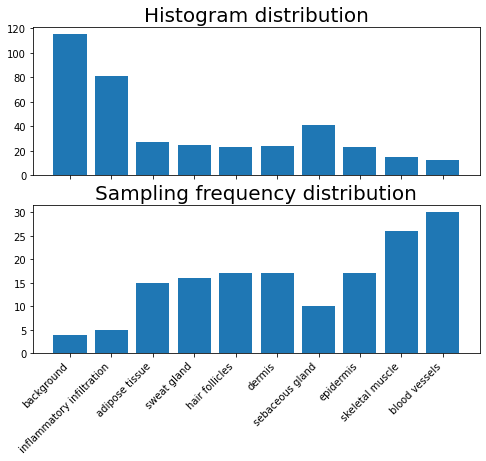

In [39]:
id2int = {}
for i, key in enumerate(valid_histogram.keys()):
    id2int[key] = i
fig3 = plt.figure(figsize=(8, 6))
ax = fig3.add_subplot(2, 1, 1)
ax.bar(np.arange(len(valid_histogram)), valid_histogram.values())
#ax.set_xticklabels([item[3] for item in cfg.DATASET.CLASS_MAP][: len(valid_histogram)], rotation=90)
ax.set_xticks(np.arange(len(valid_histogram)))
ax.set_xticklabels([])
ax.set_title("Histogram distribution", fontsize=20)
ax = fig3.add_subplot(2, 1, 2)
ax.bar(np.arange(len(valid_frequency)), valid_frequency.values())
ax.set_xticks(np.arange(len(valid_frequency)))
ax.set_xticklabels([cfg.DATASET.CLASS_MAP[id2int[key]][3] for key in valid_histogram.keys()],
                   rotation=45,
                  ha='right')
ax.set_title("Sampling frequency distribution", fontsize=20)
plt.show()

In [8]:
if type(groundtruth) is list:
    groundtruth = np.array(groundtruth)
    groundtruth = tf.keras.utils.to_categorical(groundtruth, num_classes=len(cfg.DATASET.INT_TO_CLASS))
print(predictions.shape)
print(groundtruth.shape)
pred_cls = np.argmax(predictions, axis=-1)
grou_cls = np.argmax(groundtruth, axis=-1)
print(pred_cls)
print(grou_cls)
acc = np.sum(pred_cls == grou_cls)*1.0/predictions.shape[0]
print(f"Accuracy: {acc}")

(16329, 10)
(16329, 10)
[5 8 8 ... 4 6 9]
[5 8 8 ... 7 6 9]
Accuracy: 0.9127319492926694


In [9]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# y_test (n, 0 or 1) is groundtruth
# y_score (n, 0 ~ 1) is prediction
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(groundtruth[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

'''
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(groundtruth.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
'''

'\n# Compute micro-average ROC curve and ROC area\nfpr["micro"], tpr["micro"], _ = roc_curve(groundtruth.ravel(), predictions.ravel())\nroc_auc["micro"] = auc(fpr["micro"], tpr["micro"])\n'

In [10]:
print(cfg.DATASET.HIST_NAME)
print(fpr.keys())

['background', 'inflammatory infiltration', 'adipose tissue', 'sweat gland', 'hair follicles', 'dermis', 'sebaceous gland', 'epidermis', 'skeletal muscle', 'blood vessels']
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


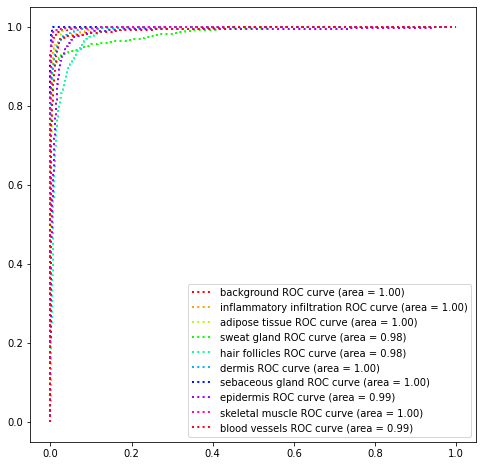

In [11]:
import matplotlib.pyplot as plt
n_classes = 10
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

'''
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
'''

# Plot all ROC curves
#cmap = plt.get_cmap('gnuplot')
cmap = plt.get_cmap('hsv')
colors = [cmap(i) for i in np.linspace(0, 1, len(fpr))]

fig10 = plt.figure(figsize=(8, 8))
ax = fig10.add_subplot(1,1,1)
for i, key in enumerate(fpr.keys()):
    ax.plot(fpr[key], tpr[key],
         label=(cfg.DATASET.HIST_NAME[int(key)])+' ROC curve (area = {0:0.2f})'
               ''.format(roc_auc[key]),
         color=colors[i], linestyle=':', linewidth=2)
    ax.legend()
plt.savefig(f"result/{reload_file.split('.h')[0]+'AUC'}.png")
plt.show()

    background  inflammatory infiltration  adipose tissue  sweat gland  \
0  1517.000000                1516.000000      1496.00000  1441.000000   
1   107.000000                  80.000000       116.00000   184.000000   
2  1624.000000                1596.000000      1612.00000  1625.000000   
3     0.934113                   0.949875         0.92804     0.886769   

   hair follicles       dermis  sebaceous gland   epidermis  skeletal muscle  \
0     1317.000000  1500.000000      1609.000000  1447.00000      1567.000000   
1      323.000000   132.000000        23.000000   177.00000       113.000000   
2     1640.000000  1632.000000      1632.000000  1624.00000      1680.000000   
3        0.803049     0.919118         0.985907     0.89101         0.932738   

   blood vessels  
0    1494.000000  
1     170.000000  
2    1664.000000  
3       0.897837  
Total accuracy: 0.9127319492926694


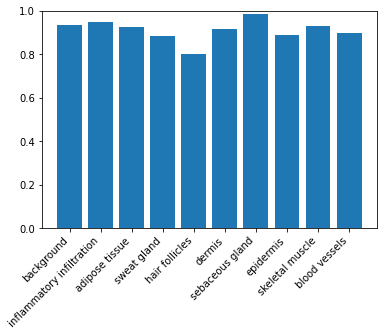

In [49]:
# compute accuracy
correct   = [0 for i in range(n_classes)]
incorrect = [0 for i in range(n_classes)]

for i in range(len(pred_cls)):
    if pred_cls[i] == grou_cls[i]:
        correct[grou_cls[i]] += 1
    else:
        incorrect[grou_cls[i]] += 1

total = [int(correct[i]+incorrect[i]) for i in range(len(correct))]
accuracy = [correct[i]*1./(total[i]) for i in range(len(correct))]

df = pd.DataFrame(np.array([correct, incorrect, total, accuracy]),
                 columns=[cfg.DATASET.HIST_NAME[i] for i in range(len(correct))])
print(df)

mask = [1 if pred_cls[i] == grou_cls[i] else 0 for i in range(grou_cls.shape[0])]
print("Total accuracy:", sum(mask)*1./len(grou_cls))

plt.bar(np.arange(len(accuracy)), accuracy)
plt.xticks(np.arange(len(accuracy)), [i[3] for i in cfg.DATASET.CLASS_MAP], rotation=45, ha='right')
plt.ylim([0, 1.0])
plt.show()

Normalized confusion matrix
[[9.34113300e-01 0.00000000e+00 6.15763547e-04 0.00000000e+00
  0.00000000e+00 1.23152709e-03 0.00000000e+00 1.47783251e-02
  1.53940887e-02 3.38669951e-02]
 [0.00000000e+00 9.49874687e-01 6.26566416e-03 2.94486216e-02
  5.63909774e-03 6.26566416e-04 5.01253133e-03 0.00000000e+00
  0.00000000e+00 3.13283208e-03]
 [0.00000000e+00 9.92555831e-03 9.28039702e-01 2.60545906e-02
  3.10173697e-03 6.20347395e-04 1.24069479e-03 0.00000000e+00
  1.86104218e-03 2.91563275e-02]
 [0.00000000e+00 1.04615385e-02 0.00000000e+00 8.86769231e-01
  9.41538462e-02 3.07692308e-03 4.92307692e-03 0.00000000e+00
  0.00000000e+00 6.15384615e-04]
 [0.00000000e+00 6.09756098e-03 0.00000000e+00 1.82926829e-03
  8.03048780e-01 2.43902439e-03 9.75609756e-03 1.73170732e-01
  0.00000000e+00 3.65853659e-03]
 [6.12745098e-04 3.30882353e-02 2.45098039e-03 3.06372549e-03
  6.12745098e-03 9.19117647e-01 4.90196078e-03 7.35294118e-03
  0.00000000e+00 2.32843137e-02]
 [0.00000000e+00 9.19117647e-0

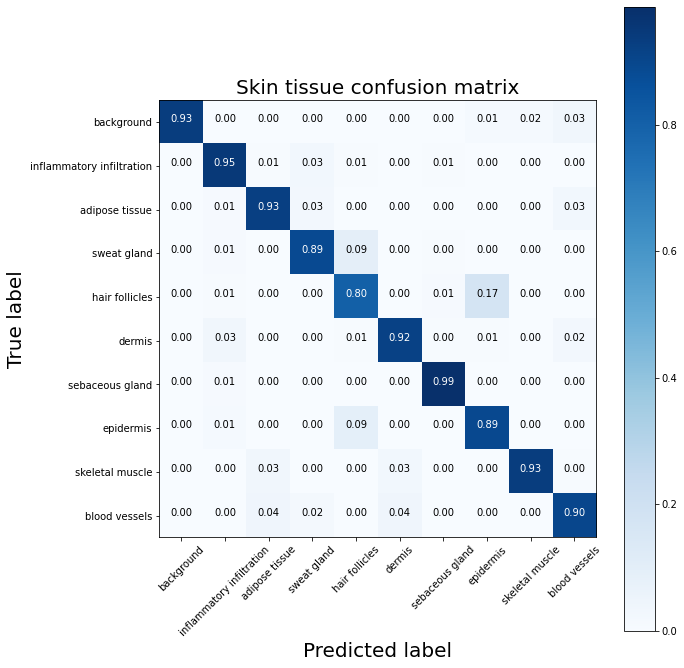

In [51]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()

# print confusion matrix
plt.figure(figsize=(10,10))
cnf_matrix = confusion_matrix(grou_cls, pred_cls)
plot_confusion_matrix(cnf_matrix, classes=[cfg.DATASET.HIST_NAME[i] for i in range(10)],normalize=True,
                    title="Skin tissue confusion matrix")

plt.savefig("result/R-101-confusion_matrix.png")
plt.show()

## Try export csv file from inference outcome

In [ ]:
slide = "/mnt/cephrbd/data/A19001_NCKU_SKIN/Image/20191106/2019-10-30 02.23.07.ndpi"
slide = Slide_ndpread(slide)
W, H = slide.get_size()
print(W, H)
print(W//512, H//512)
patch = slide.get_patch_at_level((512*165, 512*70), (512, 512))

In [ ]:
from hephaestus.compose.wsi_patch.api import PatchResultPostprocess

In [ ]:
PRP = PatchResultPostprocess(patch_size=512, raw_h=myPredictor.this_slide.get_size()[1]-512,
                             raw_w=myPredictor.this_slide.get_size()[0]-512, blur=0.)

In [ ]:
myPredictor.this_slide.get_size()

In [ ]:
tmp = myPredictor.prob_map

print(tmp.shape)
back  = np.zeros((myPredictor.w_stride, myPredictor.h_stride, 1))
back[myPredictor.background_mask.transpose()] = 1
out = np.concatenate([tmp, back], axis=2)
print(out)

In [ ]:
out.shape

In [ ]:
'''
root@80f26a2f0117:/workspace/skin# cd /mnt/cephrbd/data/A19001_NCKU_SKIN/Meta/
root@80f26a2f0117:/mnt/cephrbd/data/A19001_NCKU_SKIN/Meta# cat annot-pk-reference.json 
{
    "80": "Muscle",
    "56": "Inflammatory infiltration",
    "55": "Blood vessel",
    "54": "Sebaceous gland",
    "53": "Sweat gland",
    "45": "Hair follicle",
    "44": "Unspecified",
    "43": "Adipose tissue",
    "42": "Dermis (Collagen fiber and fibroblasts)",
    "41": "Epidermis"
}
'''
result_dir = "/workspace/skin/result/inference_CSV/"
target_folder= os.path.join(result_dir, "12345")
if not os.path.exists(target_folder):
    os.makedirs(target_folder)
d = PRP.run(prediction=myPredictor.get_np_pred(),  
            result_dir=result_dir, target_folder=target_folder)
print(d)

In [ ]:
import pandas
d = pandas.read_csv(target_folder+"/df.csv")
d

In [ ]:
import matplotlib.image as mpimg

slide_list = [
"2019-10-30 01.59.42.",
"2019-10-30 02.01.19.",
"2019-10-30 02.02.21.",
"2019-10-30 02.03.40.",
"2019-10-30 02.04.50.",
"2019-10-30 02.05.46.",
"2019-10-30 02.07.27.",
"2019-10-30 02.09.05.",
"2019-10-30 02.10.47.",
"2019-10-30 02.14.37.",
"2019-10-30 02.15.32.",
"2019-10-30 02.18.03.",
"2019-10-30 02.19.24.",
"2019-10-30 02.23.07.",
"350013D01170 - 2019-10-30 02.21.40."   
]

def plot_threshold(fig, slide_name):
    for i in range(10):
        ax = fig.add_subplot(5, 2, i+1)
        img = mpimg.imread('result/inference_CSV/'+slide_name+'/alpha_thres-0.'+str(i)+'00.png')
        ax.set_xticks([])
        ax.set_yticks([])
        ax_title = "Slide:"+ slide_name + ", alpha threshold={:.1f}".format(0.1*i)
        ax.set_title(ax_title,fontsize=12)
        ax.imshow(img, interpolation='nearest')
    fig.tight_layout()
    import os
    save_path = "/workspace/skin/result/heatmap/"
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path, slide_name))
    plt.clf() 
    
fig2 = plt.figure(figsize=(20, 15))
for i in range(len(slide_list)):
    plot_threshold(fig2, slide_list[i])

## 5-crop method model
### Try not inference on the same corner 4 times!

In [ ]:
class InfDataSet:
    def __init__(self,
                 slide_dir,
                 slide_name,
                 patch_size,
                 hsv_threshold=0.05):
        self.this_slide = Slide_ndpread(os.path.join(slide_dir, slide_name))
        self.hsv_threshold = hsv_threshold
        self.patch_size = patch_size
        
        W, H = self.this_slide.get_size()
        w, h = patch_size[0], patch_size[1]
        self.W = W
        self.H = H
        
        self.w_stride = W//w if W%w==0 else W//w+1
        self.h_stride = H//h if H%h==0 else H//h+1
        
        assert W//w*w <= W and H//h*h <= H
        self.tiny_slide = self.this_slide.get_patch_with_resize(coord=(0,0),
                                                                src_sz = (W//w*w, H//h*h),
                                                                dst_sz = (W//w, H//h)
                                                               )
        self.tiny_slide = np.pad(self.tiny_slide, 
                                 ((0, self.h_stride-self.tiny_slide.shape[0]),
                                  (0, self.w_stride-self.tiny_slide.shape[1]), 
                                  (0, 0)), 
                                 mode="reflect")
        
        # get non-background patches and their
        self.object_mask     = None
        self.five_crop_mask  = None
        self._judge_bg()
        self._get_crop_mask()
        
        # collect all patches that will be inferenced on
        # labels: (hi, wi)
        self.coords = None
        self._collect_label()
        
        # current position
        self.cur_pos = 0
    
    def _collect_label(self):
        xs,  ys  = np.where(self.object_mask > 0)
        xss, yss = np.where(self.five_crop_mask > 0)
        xss = xss.astype(np.float32) - 0.5
        yss = yss.astype(np.float32) - 0.5
        xs  = np.concatenate([xs.astype(np.float32), xss], axis=-1)
        ys  = np.concatenate([ys.astype(np.float32), yss], axis=-1)
        self.coords = list(zip(xs, ys))
        
    def _judge_bg(self, expand=True):
        hsv_img = rgb2hsv(self.tiny_slide)
        saturation_img = hsv_img[:, :, 1]
        boolean_mask = np.array(saturation_img>self.hsv_threshold, dtype=np.int32)
        if not expand:
            self.object_mask = boolean_mask
            return
        for w in range(boolean_mask.shape[1]):
            meet = 0
            for h in range(boolean_mask.shape[0]):
                if boolean_mask[h, w] == 1:
                    meet = 2
                elif meet > 0:
                    boolean_mask[h, w] = 1
                    meet -= 1
            meet = 0
            for h in range(boolean_mask.shape[0])[::-1]:
                if boolean_mask[h, w] == 1:
                    meet = 2
                elif meet > 0:
                    boolean_mask[h, w] = 1
                    meet -= 1
        self.object_mask = boolean_mask
    
    def _get_crop_mask(self):
        self.five_crop_mask = np.zeros((self.object_mask.shape[0]+1, self.object_mask.shape[1]+1))
        dirs = [((0, 1), (0, 1)), ((0, 1), (1, 0)), ((1, 0), (0, 1)), ((1, 0), (1, 0))]
        for dir in dirs:
            self.five_crop_mask += np.pad(self.object_mask, dir, 'constant', constant_values=(0, 0))
    
    def __getitem__(self, idx):
        self.cur_pos = idx
        h, w = int(self.coords[idx][0]*self.patch_size[1]), int(self.coords[idx][1]*self.patch_size[0])
        img = self.this_slide.get_patch_at_level((w, h), self.patch_size)/255.
        
        self.cur_pos = (self.cur_pos+1)%len(self)
        return img, np.array(list(self.coords[idx]))
    
    def get_coords(self):
        return self.coords
    
    def get_mask(self):
        return np.copy(self.object_mask)
    
    def __next__(self):
        return self.__getitem__(self.cur_pos)
        
    def __len__(self):
        return len(self.coords)
    

class InfLoader(Sequence):
    def __init__(self,
                dataset,
                batch_size=32):
        self.dataset = dataset
        self.batch_size = batch_size
    
    def __getitem__(self, idx):
        imgs      = []
        poss      = []
        for i in range(idx*self.batch_size, min((idx+1)*self.batch_size, len(self.dataset))):
            img, pos = self.dataset[i]
            imgs.append(img)
            poss.append(pos)
        imgs = np.array(imgs)
        poss = np.array(poss)
        return imgs, poss
    
    def __len__(self):
        return math.ceil(len(self.dataset)*1./self.batch_size)
    

In [ ]:
inference_dataset = InfDataSet(slide_dir=cfg.DATASET.SLIDE_DIR,
                 slide_name=cfg.DATASET.TRAIN_SLIDE[0],
                 patch_size=cfg.DATASET.INPUT_SHAPE[:2],
                 hsv_threshold=0.05)

In [ ]:
COLOR_LIST = [(255, 255, 255), (255, 87, 34), (233, 30, 99), (205, 220, 57), (0, 0, 153), (76, 175, 80), (156, 39, 176), (3, 169, 244), (255, 0, 0), (181, 136, 24)]

In [ ]:
class PRPMgr:
    def __init__(self, dataset, model, center_weight=1, batch_size=32):
        inference_dataset = dataset
        inference_loader  = InfLoader(inference_dataset, batch_size)
        self.output = model.predict(inference_loader, verbose=1, workers=5)
        self.coords = inference_dataset.get_coords()
        
        self.center_weight = center_weight
        self.object_mask = inference_dataset.object_mask
        self.H = self.object_mask.shape[0]
        self.W = self.object_mask.shape[1]
        self.dirs = [(0, 0), (1, 0), (0, 1), (1, 1)]
        assert self.output.shape[0] == len(self.coords)
        self.heatmap = np.zeros((self.H, self.W, 2+self.output.shape[1]), dtype=np.float64)
        for h in range(self.H):
            for w in range(self.W):
                self.heatmap[h, w, 0] = w
                self.heatmap[h, w, 1] = h
        background_mask = np.logical_not(self.object_mask)
        self.heatmap[background_mask, 2] = 1
        self.fill_in_probability()
        
    def fill_in_probability(self):
        corner_heatmap = np.zeros((self.object_mask.shape[0]+1, 
                                   self.object_mask.shape[1]+1, 
                                   self.output.shape[1]), dtype=np.float64)
        for i, (h, w) in enumerate(self.coords):
            h2 = int(h*2)
            w2 = int(w*2)
            if (h2)%2 == 0 and (w2)%2 == 0:
                h, w = h2//2, w2//2
                assert self.heatmap[h, w, 2] == 0
                self.heatmap[h, w, 2:] = np.copy(self.output[i])
            elif (h2)%2 == 1 and (w2)%2 == 1:
                h, w = (h2+1)//2, (w2+1)//2
                assert corner_heatmap[h, w, 0] == 0
                corner_heatmap[h, w] = np.copy(self.output[i])
            else:
                print(f"Coordinate {h}, {w} is not found!")
                raise ValueError
        hs, ws = np.where(self.object_mask > 0)
        for i in range(hs.shape[0]):
            h, w = hs[i], ws[i]
            self.heatmap[h, w, 2:] *= self.center_weight
            for dh, dw in self.dirs:
                self.heatmap[h, w, 2:] += corner_heatmap[h+dh, w+dw]
            self.heatmap[h, w, 2:] /= (self.center_weight+4)
    
    def get_heatmap(self):
        return self.heatmap.reshape((-1, self.heatmap.shape[-1]))
    
    def visualize_heatmap(self, ax):
        class_map = np.argmax(self.heatmap[..., 2:], axis=-1)
        color_list= np.array(COLOR_LIST)
        color_layers = []
        for i in range(3):
            color_layers.append(color_list[class_map][...,i])
        colored_image = np.stack(color_layers, axis = -1)
        ax.imshow(colored_image)
            

In [ ]:
prpMgr = PRPMgr(inference_dataset, model, center_weight=5, batch_size=32)
prpMgr.get_heatmap()

## Plot training accuracy with respect to epoch

In [ ]:
df = pd.read_csv("/workspace/skin/checkpoint/R-101-v1_512_E50_cls10_AUG.csv")
labels = df.columns
fig2 = plt.figure(figsize=(10, 8))
ax1 = fig2.add_subplot(2, 1, 1)
ax2 = fig2.add_subplot(2, 1, 2)
for label in labels:
    if label.endswith("loss"):
        ax2.plot(np.arange(len(df[label])), df[label], label=label)
    else:
        ax1.plot(np.arange(len(df[label])), df[label], label=label)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax1.legend()
ax2.legend()
plt.savefig("/workspace/skin/result/R-101-v1_512_E50_cls10_AUG_acc.png")